In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../"))

## First checkout serial misstatements

Let's count the cases where the same company has a misstatement in the train.

In [43]:
import pandas as pd
from collections import defaultdict


previous_misstatement = defaultdict(int)
target_col = 'Misstatement'
company_id_col = 'CIK'

path_to_files = "../data/"
folder_files = [f'split_{year_int}' for year_int in range(2003, 2015)]
counts = []
for folder in folder_files:
    df_train = pd.read_csv(os.path.join(path_to_files, folder, "train_instances.csv"))
    df_train[['CIK', 'SIC']] = df_train[['CIK', 'SIC']].astype(int)
    # df_train['previous_misstatement'] = df_train['CIK'].map(previous_misstatement)   
    
    df_test = pd.read_csv(os.path.join(path_to_files, folder, "test_instances.csv"))
    df_test[['CIK', 'SIC']] = df_test[['CIK', 'SIC']].astype(int)
    
    already_seen_names = df_train[df_train[target_col] == 1][company_id_col]
    num_train = len(already_seen_names)
    num_unq_train = len(set(already_seen_names))
    num_test = df_test[df_test[target_col]==1].shape[0]
    num_test_in_train = df_test[(df_test[target_col]==1) & (df_test[company_id_col].isin(already_seen_names))].shape[0]
    num_train_in_test = df_train[(df_train[target_col]==1) & (df_train[company_id_col].isin(df_test[df_test[target_col]==1][company_id_col]))].shape[0]
    counts.append((int(folder.split("_")[1]), num_train, num_unq_train, num_test, num_test_in_train, num_train_in_test))
    #break
counts_df = pd.DataFrame(counts, columns=['split', 'pos_train', 'unq_pos_train', 'pos_test', 'test_in_train', 'train_in_test'])
counts_df['perc_test_in_train'] = counts_df['test_in_train'] / counts_df['pos_test']
counts_df['perc_train_in_test'] = counts_df['train_in_test'] / counts_df['pos_train']
counts_df

,split,pos_train,unq_pos_train,pos_test,test_in_train,train_in_test,perc_test_in_train,perc_train_in_test
0,2003,184,130,93,46,77,0.494624,0.418478
1,2004,228,156,87,39,76,0.448276,0.333333
2,2005,239,159,82,34,76,0.414634,0.317992
3,2006,199,135,61,18,37,0.295082,0.185930
4,2007,183,140,54,15,27,0.277778,0.147541
5,2008,151,123,66,12,28,0.181818,0.185430
6,2009,125,103,69,15,23,0.217391,0.184000
7,2010,125,104,80,16,28,0.200000,0.224000
8,2011,139,114,75,13,25,0.173333,0.179856
9,2012,135,110,86,12,21,0.139535,0.155556


## Historicity
1. We see indeed that the **first 3 years we have 39-50% of the test misttaters being serial ones**.
2. We see that as time goes on the serial-historicity drops in ''recall'' and ''precision'' both.

## Let's also check the number of companies for which we have data that we can compare against


In [50]:
import pandas as pd
import numpy as np
path_to_files = "../data/"
folder_files = [f'split_{year_int}' for year_int in range(2003, 2015)]
counts = []
for folder in folder_files:
    df_train = pd.read_csv(os.path.join(path_to_files, folder, "train_instances.csv"))
    df_train[['CIK', 'SIC']] = df_train[['CIK', 'SIC']].astype(int)
    # df_train['previous_misstatement'] = df_train['CIK'].map(previous_misstatement)   
    
    df_test = pd.read_csv(os.path.join(path_to_files, folder, "test_instances.csv"))
    df_test[['CIK', 'SIC']] = df_test[['CIK', 'SIC']].astype(int)
    
    num_test = df_test[df_test[target_col]==1].shape[0]
    counts_dict = df_test[company_id_col].apply(lambda x: (df_train[company_id_col] == x).sum()).value_counts().to_dict()
    counts_np = np.zeros(4)
    for index,val in counts_dict.items():
        counts_np[index] = val / df_test.shape[0]
    
    num_pos_with_no_prev = df_test[(df_test[company_id_col].apply(lambda x: (df_train[company_id_col] == x).sum()) == 0) & (df_test[target_col]==1)].shape[0]
    
    
    counts.append([int(folder.split("_")[1]), num_test] + counts_np.tolist() + [num_pos_with_no_prev])
    #break
counts_df = pd.DataFrame(counts, columns=['split', 'pos_test', '0', '1', '2', '3', 'num_pos_with_no_prev'])
counts_df

,split,pos_test,0,1,2,3,num_pos_with_no_prev
0,2003,93,0.073935,0.275376,0.265664,0.385025,5
1,2004,87,0.077627,0.102240,0.363522,0.456611,9
2,2005,82,0.084489,0.086424,0.153499,0.675589,6
3,2006,61,0.098392,0.096463,0.147910,0.657235,11
4,2007,54,0.108325,0.107361,0.131469,0.652845,6
5,2008,66,0.134470,0.110164,0.132576,0.622790,10
6,2009,69,0.075478,0.134111,0.145125,0.645287,8
7,2010,80,0.056616,0.085912,0.193878,0.663594,6
8,2011,75,0.056203,0.074709,0.145990,0.723098,5
9,2012,86,0.056670,0.070750,0.124604,0.747976,6


1. Only **5-13% cases of "new" companies**.
2. Usually we will have **2-3 previous records** (average 66-87%).
3. **2-10% are the cases where a first-timer is a misstater**. Interesting to see whether the classic models can capture those. 
    1. This should be **irreducible error** following a per-company model (we could delegate to default one).

In [109]:

from pu_finance.utils import METADATA_TO_USE, FINANCIAL_FEATURES
from pu_finance.metrics import get_ranking_scores
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score


path_to_files = "../data/"
folder_files = [f'split_{year_int}' for year_int in range(2003, 2015)]
counts = []

use_metadata = True
random_state = 42
if use_metadata:
    to_keep = METADATA_TO_USE + FINANCIAL_FEATURES 
    cat_features = [0,1,2]
else:
    to_keep = FINANCIAL_FEATURES
    cat_features = []


for folder in folder_files:
    df_train = pd.read_csv(os.path.join(path_to_files, folder, "train_instances.csv"))
    df_train[['CIK', 'SIC']] = df_train[['CIK', 'SIC']].astype(int)
    # df_train['previous_misstatement'] = df_train['CIK'].map(previous_misstatement)   
    
    df_test = pd.read_csv(os.path.join(path_to_files, folder, "test_instances.csv"))
    df_test[['CIK', 'SIC']] = df_test[['CIK', 'SIC']].astype(int)
    


    train = df_train[to_keep + [target_col]].dropna()
    X_train = train[to_keep].values
    y_train = train[target_col].values.astype(int)
    
    test = df_test[to_keep + [target_col]]
    X_test = test[to_keep].values
    y_test = test[target_col].values.astype(int)
    
    counts_dict = test[test[target_col]==1][company_id_col].apply(lambda x: (train[company_id_col] == x).sum()).value_counts().to_dict()
    counts_np = np.zeros(4)
    for index,val in counts_dict.items():
        counts_np[index] = val 
        
    assert counts_np.sum() == y_test.sum()
    
    # declare classifier
    clf = Pipeline(
        [
            (
                "tr",
                make_column_transformer(
                    [OneHotEncoder(handle_unknown="ignore"), cat_features],
                    remainder="passthrough",
                ),
            ),
            ("imp", SimpleImputer(strategy="mean")),
            ("sc", StandardScaler(with_mean=False)),
            (
                "clf",
                LogisticRegression(
                    random_state=random_state, class_weight="balanced", max_iter=1000
                ),
            ),
        ]
    )


    clf.fit(X_train, y_train)
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    
    
    
    
    rankings = get_ranking_scores(y_test, y_test_proba)
    test['pred_proba']= y_test_proba
    test['pred'] = (y_test_proba > 0.5).astype(int)
    test.loc['num_seen'] = test[company_id_col].apply(lambda x: (train[company_id_col] == x).sum())
    f1 = {}
    for num_seen in range(4):
        strata = test[test['num_seen'] == num_seen]
        f1[num_seen] = f1_score(strata[target_col], strata['pred'], average='binary')

    counts.append([int(folder.split("_")[1]), y_test.sum()] + counts_np.tolist() + list(f1.values()))
    #break
counts_df = pd.DataFrame(counts, columns=['split', 'num_pos_test', '0', '1', '2', '3', 'f1_0', 'f1_1', 'f1_2', 'f1_3'])
counts_df

/tmp/ipykernel_727499/2481226490.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_proba']= y_test_proba
/tmp/ipykernel_727499/2481226490.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = (y_test_proba > 0.5).astype(int)
/tmp/ipykernel_727499/2481226490.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,split,num_pos_test,0,1,2,3,f1_0,f1_1,f1_2,f1_3
0,2003,93,10.0,28.0,25.0,30.0,0.000000,0.652174,0.603774,0.393939
1,2004,87,14.0,7.0,33.0,33.0,0.000000,0.666667,0.410256,0.340909
2,2005,82,6.0,7.0,20.0,49.0,0.090909,0.533333,0.307692,0.352113
3,2006,61,14.0,6.0,12.0,29.0,0.000000,0.444444,0.173913,0.282828
4,2007,54,9.0,5.0,6.0,34.0,0.000000,0.600000,0.300000,0.152381
5,2008,66,17.0,8.0,4.0,37.0,0.037736,0.000000,0.222222,0.222222
6,2009,69,19.0,14.0,6.0,30.0,0.062500,0.090909,0.352941,0.222222
7,2010,80,17.0,3.0,15.0,45.0,0.000000,0.000000,0.214286,0.176471
8,2011,75,14.0,3.0,8.0,50.0,0.000000,0.285714,0.181818,0.153846
9,2012,86,10.0,11.0,16.0,49.0,0.000000,0.142857,0.076923,0.157895


In [110]:
counts_df.mean()

split           2008.500000
num_pos_test      78.833333
0                 14.083333
1                  8.166667
2                 13.916667
3                 42.666667
f1_0               0.033348
f1_1               0.284675
f1_2               0.260795
f1_3               0.220654
dtype: float64

1. As expected **average f1** for cases we have not seen them before is abysmall **0.04 vs 0.22-0.3 on average**.
2. Interestingly enough **we do better in the cases where we only have 1 previous occurence** of the company in data (in 6/12 cases).
    1. Only cases where other are better are: for 3-peat 2008,2010,2012,2014 ; for 2-peat 2009, 2013.


## Add dumb historical thing

1. In train set:
    1. Create pairs of (newer, older) financial feature vectors.
    2. Create a feature vector for each one as (X_newer[FIN_FEATS] - X_older[FIN_FEATS])/X_older[FIN_FEATs].
    3. This encompasses the scaled changed at each year.
    4. For each such feature vector the label is the label of newer instance.
    5. Train classifier each fold with this.
2. At test time:
    1. Find the companies for which we have previous data.
    2. Create the scaled feature vector for these companies with the earlier feature vector.
    3. Run inference.
    4. Use 3 for probas on those we have data and use the default for the rest.

In [235]:
def get_train_feature_vectors(df_train_cur):
    multiple_vals = df_train_cur[df_train_cur.duplicated(subset=company_id_col, keep=False)].sort_values([company_id_col, 'Date']).set_index(company_id_col)
    multiple_vals[FINANCIAL_FEATURES] = multiple_vals[FINANCIAL_FEATURES].fillna(multiple_vals[FINANCIAL_FEATURES].mean())
    epsilon = 1e-6
    X_pairs = []
    y_pairs = []
    for unq_company in multiple_vals.index.unique():
        subset = multiple_vals.loc[unq_company]
        c = 0
        for current_index in range(1,subset.shape[0])[::-1]:
            current_fins = (subset.iloc[current_index][FINANCIAL_FEATURES] - subset.iloc[current_index - 1][FINANCIAL_FEATURES]).values/(subset.iloc[current_index - 1][FINANCIAL_FEATURES] + epsilon)
            X_pairs.append(current_fins)
            y_pairs.append(subset.iloc[current_index][target_col])
            c += y_pairs[-1]
        assert c == subset.iloc[1:][target_col].sum()
    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)
    return X_pairs, y_pairs


# multiple_vals = df_train[df_train.duplicated(subset=company_id_col, keep=False)].sort_values([company_id_col, 'Date']).set_index(company_id_col)
# multiple_vals[FINANCIAL_FEATURES] = multiple_vals[FINANCIAL_FEATURES].fillna(multiple_vals[FINANCIAL_FEATURES].mean())
# epsilon = 1e-6
# X_pairs = []
# y_pairs = []
# c_total = 0
# for unq_company in multiple_vals.index.unique():
#     subset = multiple_vals.loc[unq_company]
#     c_total += sum(subset[target_col])
#     c = 0
#     print('\n', unq_company)
#     for current_index in range(1,subset.shape[0])[::-1]:
        
#         current_fins = (subset.iloc[current_index][FINANCIAL_FEATURES] - subset.iloc[current_index - 1][FINANCIAL_FEATURES]).values/(subset.iloc[current_index - 1][FINANCIAL_FEATURES] + epsilon)
#         X_pairs.append(current_fins)
#         y_pairs.append(subset.iloc[current_index][target_col])
#         print(current_index, y_pairs[-1])
#         c += y_pairs[-1]

#     assert c == subset.iloc[1:][target_col].sum()
#     if sum(y_pairs) > c_total:
#         print('PROBLEM', sum(y_pairs), c_total)
#         break
# X_pairs = np.array(X_pairs)
# y_pairs = np.array(y_pairs)



act           -0.003057
ap            -0.001784
at            -0.001719
ceq           -0.001577
che            0.006923
cogs          -0.003879
csho           0.027956
dlc           -0.000397
dltis         -0.005012
dltt          -0.003814
dp            -0.002256
ib             0.002395
invt           0.001115
ivao          -0.003707
ivst          -0.005911
lct           -0.000916
lt            -0.000236
ni             0.003182
ppegt         -0.001988
pstk           0.065631
re             0.001627
rect          -0.003555
sale          -0.003023
sstk           0.022112
txp           -0.001404
txt            0.001247
xint          -0.002891
prcc_f        -0.003521
dch_wc         0.004472
ch_rsst       -0.001563
dch_rec       -0.003302
dch_inv       -0.006253
soft_assets    0.004603
ch_cs         -0.001568
ch_cm          0.002244
ch_roa        -0.011763
issue         -0.006544
bm            -0.001525
dpi           -0.011635
reoa           0.001681
EBIT          -0.000677
Name: Misstateme

In [256]:


from pu_finance.utils import METADATA_TO_USE, FINANCIAL_FEATURES
from pu_finance.metrics import get_ranking_scores
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score


path_to_files = "../data/"
folder_files = [f'split_{year_int}' for year_int in range(2003, 2015)]
counts = []

use_metadata = False
random_state = 42
if use_metadata:
    to_keep = METADATA_TO_USE + FINANCIAL_FEATURES 
    cat_features = [0,1,2]
else:
    to_keep = FINANCIAL_FEATURES
    cat_features = []

feat_corrs = []
for folder in folder_files:
    df_train = pd.read_csv(os.path.join(path_to_files, folder, "train_instances.csv"))
    df_train[['CIK', 'SIC']] = df_train[['CIK', 'SIC']].astype(int)
    # df_train['previous_misstatement'] = df_train['CIK'].map(previous_misstatement)   
    
    df_test = pd.read_csv(os.path.join(path_to_files, folder, "test_instances.csv"))
    df_test[['CIK', 'SIC']] = df_test[['CIK', 'SIC']].astype(int)
    


    train = df_train[to_keep + [target_col]].dropna()
    X_train = train[to_keep].values
    y_train = train[target_col].values.astype(int)
    
    test = df_test[to_keep + [target_col]]
    X_test = test[to_keep].values
    y_test = test[target_col].values.astype(int)
    
    counts_dict = df_test[df_test[target_col]==1][company_id_col].apply(lambda x: (df_train[company_id_col] == x).sum()).value_counts().to_dict()
    counts_np = np.zeros(4)
    for index,val in counts_dict.items():
        counts_np[index] = val 
        
    assert counts_np.sum() == y_test.sum()
    
    # declare classifier
    clf = Pipeline(
        [
            (
                "tr",
                make_column_transformer(
                    [OneHotEncoder(handle_unknown="ignore"), cat_features],
                    remainder="passthrough",
                ),
            ),
            ("imp", SimpleImputer(strategy="mean")),
            ("sc", StandardScaler(with_mean=False)),
            (
                "clf",
                LogisticRegression(
                    random_state=random_state, class_weight="balanced", max_iter=1000
                ),
            ),
        ]
    )


    clf.fit(X_train, y_train)
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    rankings_old = get_ranking_scores(y_test, y_test_proba)
    
   
    test['num_seen'] = df_test[company_id_col].apply(lambda x: (df_train[company_id_col] == x).sum())
    
    X_pairs, y_pairs = get_train_feature_vectors(df_train)
    indices_to_predict = test[test['num_seen'] >0].index.values
    
    train_latest_vals = df_train.sort_values('Date').drop_duplicates([company_id_col], keep='last').set_index(company_id_col)[FINANCIAL_FEATURES]
    train_latest_vals = train_latest_vals.fillna(train_latest_vals.mean())
    train2feats = train_latest_vals.to_dict(orient='index')
    
    X_test_old_vals = np.array(df_test.iloc[indices_to_predict][company_id_col].apply(lambda x: np.array(list(train2feats[x].values()))).tolist())
    X_test_pairs = (df_test.iloc[indices_to_predict][FINANCIAL_FEATURES].values - X_test_old_vals)/(X_test_old_vals + 1e-6)
    
    # declare classifier
    clf2 = Pipeline(
        [
            ("imp", SimpleImputer(strategy="mean")),
            ("sc", StandardScaler(with_mean=False)),
            (
                "clf",
                LogisticRegression(
                    random_state=random_state, class_weight="balanced", max_iter=1000
                ),
            ),
        ]
    )


    clf2.fit(X_pairs, y_pairs)
    y_test_proba2 = clf2.predict_proba(X_test_pairs)[:, 1]
    y_test_proba[indices_to_predict] = y_test_proba2
    
    
    test['pred_proba']= y_test_proba
    test['pred'] = (y_test_proba > 0.5).astype(int)
    
    rankings = get_ranking_scores(y_test, y_test_proba)
    
    # train_scaled = pd.DataFrame(X_pairs, columns=FINANCIAL_FEATURES)
    # train_scaled[target_col] = y_pairs
    # feat_corrs.append(train_scaled.corr()[target_col][:-1])
    feat_corrs.append(clf2.steps[-1][1].coef_)


    counts.append([int(folder.split("_")[1]), y_test.sum()] + list(rankings_old.values()) + list(rankings.values()))
    #break
counts_df = pd.DataFrame(counts, columns=['split', 'num_pos_test'] + list(rankings) + [item + "__scaled" for item in list(rankings)])
counts_df

/tmp/ipykernel_727499/4028016056.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['num_seen'] = df_test[company_id_col].apply(lambda x: (df_train[company_id_col] == x).sum())
/tmp/ipykernel_727499/4028016056.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_proba']= y_test_proba
/tmp/ipykernel_727499/4028016056.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,split,num_pos_test,average_precision,ndcg-precision,rec-precision,average_precision__scaled,ndcg-precision__scaled,rec-precision__scaled
0,2003,93,0.045614,0.072297,0.086022,0.034575,0.056590,0.064516
1,2004,87,0.035742,0.039444,0.034483,0.026276,0.009845,0.011494
2,2005,82,0.041828,0.078374,0.085366,0.051300,0.103919,0.060976
3,2006,61,0.026125,0.012245,0.016393,0.023950,0.032738,0.032787
4,2007,54,0.022530,0.027088,0.037037,0.019088,0.000000,0.000000
5,2008,66,0.025792,0.027507,0.030303,0.032299,0.082651,0.045455
6,2009,69,0.030427,0.041984,0.043478,0.023065,0.039311,0.043478
7,2010,80,0.029354,0.024509,0.025000,0.023575,0.010314,0.012500
8,2011,75,0.043796,0.087405,0.066667,0.025969,0.014642,0.013333
9,2012,86,0.052174,0.082796,0.081395,0.043404,0.068298,0.058140


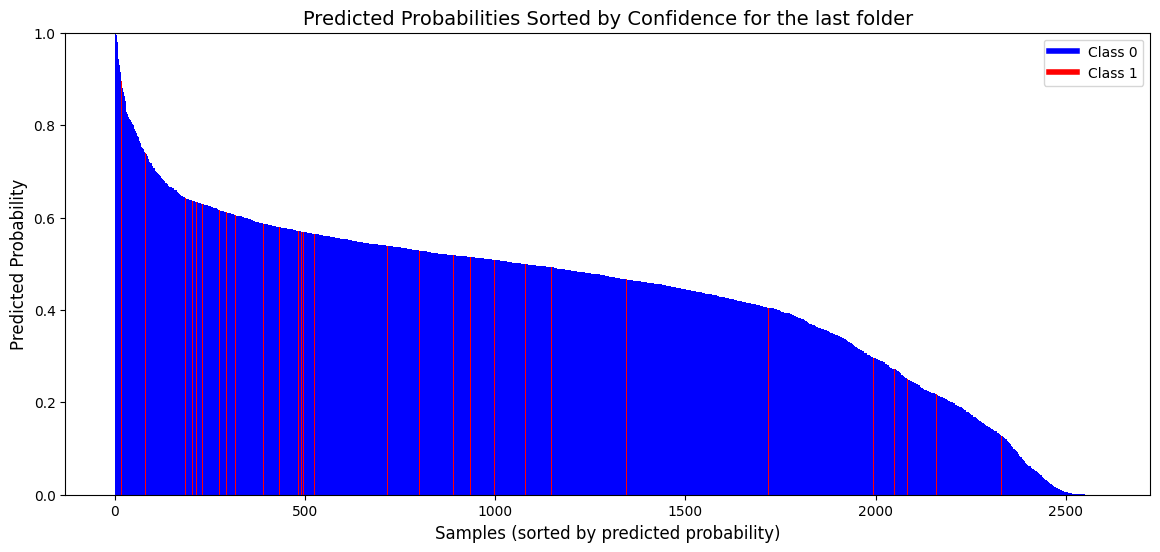

In [268]:
y_test_proba_original = clf.predict_proba(X_test[indices_to_predict])[:,1]

import matplotlib.pyplot as plt

# Sort data by predicted probabilities
sorted_indices = np.argsort(y_test_proba_original)[::-1]  # Sort in descending order
sorted_probs = y_test_proba_original[sorted_indices]
sorted_labels = y_test[indices_to_predict][sorted_indices]

# Define colors based on labels
colors = ['blue' if label == 0 else 'red' for label in sorted_labels]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(y_test[indices_to_predict])), sorted_probs, color=colors, width=1)

# Labels and aesthetics
plt.xlabel("Samples (sorted by predicted probability)", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.title("Predicted Probabilities Sorted by Confidence for the last folder", fontsize=14)
plt.ylim(0, 1)

# Custom legend
plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='Class 0'),
    plt.Line2D([0], [0], color='red', lw=4, label='Class 1')
], loc="upper right")

plt.show()

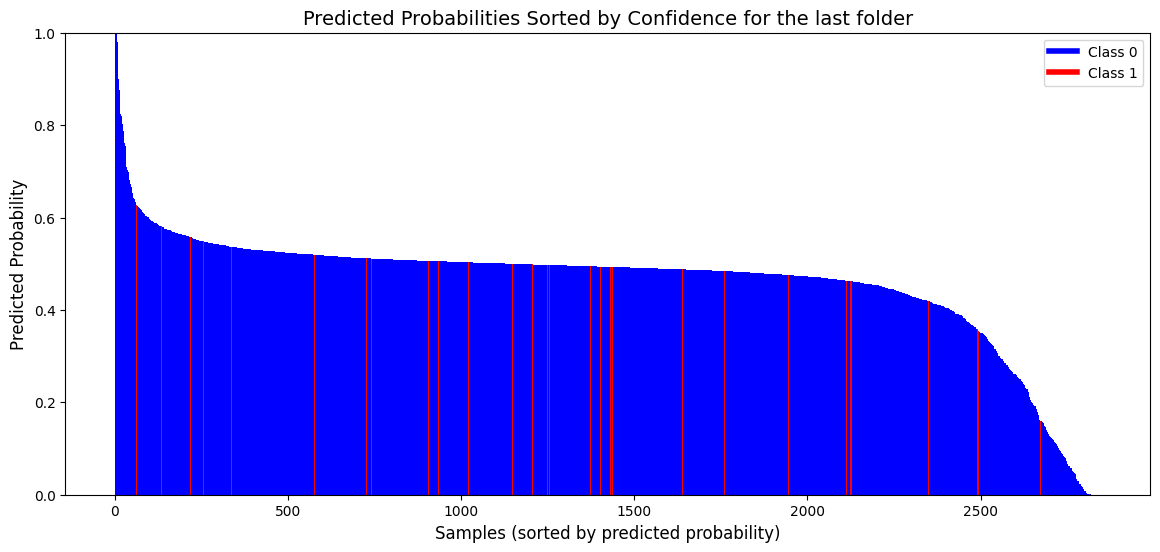

In [266]:
import matplotlib.pyplot as plt

# Sort data by predicted probabilities
sorted_indices = np.argsort(y_test_proba)[::-1]  # Sort in descending order
sorted_probs = y_test_proba[sorted_indices]
sorted_labels = y_test[sorted_indices]

# Define colors based on labels
colors = ['blue' if label == 0 else 'red' for label in sorted_labels]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(y_test)), sorted_probs, color=colors, width=1)

# Labels and aesthetics
plt.xlabel("Samples (sorted by predicted probability)", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.title("Predicted Probabilities Sorted by Confidence for the last folder", fontsize=14)
plt.ylim(0, 1)

# Custom legend
plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='Class 0'),
    plt.Line2D([0], [0], color='red', lw=4, label='Class 1')
], loc="upper right")

plt.show()

In [257]:
counts_df.mean()

split                        2008.500000
num_pos_test                   78.833333
average_precision               0.036766
ndcg-precision                  0.049467
rec-precision                   0.050763
average_precision__scaled       0.031243
ndcg-precision__scaled          0.041387
rec-precision__scaled           0.035474
dtype: float64

In [258]:
counts_df[counts_df['average_precision'] < counts_df['average_precision__scaled']]

,split,num_pos_test,average_precision,ndcg-precision,rec-precision,average_precision__scaled,ndcg-precision__scaled,rec-precision__scaled
2,2005,82,0.041828,0.078374,0.085366,0.051300,0.103919,0.060976
5,2008,66,0.025792,0.027507,0.030303,0.032299,0.082651,0.045455


1. Initial results do not seem to work (only in 2/12 years).
    1. Check for bugs.
    2. Work on the procedure/variants.
        1. It was trained on supposedly year-year case. Should we make sure that in test we only change the ones we have 1 year distance?
        2. We scale them to be agnostic of the background and make it company agnostic. Is this something to work on?
        3. ...

In [259]:
feat_corrs = np.vstack((feat_corrs))
for feat_index in np.argsort(np.abs(feat_corrs.mean(axis=0)))[::-1]:
    print(f"({feat_index}) {to_keep[feat_index]} : {feat_corrs.mean(axis=0)[feat_index]:.3f}")

(7) dlc : -1.376
(27) prcc_f : -1.164
(26) xint : -1.104
(31) dch_inv : -1.020
(32) soft_assets : -0.992
(23) sstk : -0.885
(5) cogs : -0.789
(19) pstk : -0.729
(0) act : -0.724
(21) rect : -0.710
(9) dltt : -0.697
(12) invt : -0.633
(14) ivst : -0.603
(22) sale : -0.598
(24) txp : -0.590
(13) ivao : -0.554
(4) che : -0.550
(30) dch_rec : -0.439
(10) dp : -0.417
(28) dch_wc : -0.386
(8) dltis : -0.318
(15) lct : -0.315
(16) lt : 0.313
(6) csho : -0.311
(18) ppegt : -0.288
(17) ni : 0.248
(2) at : 0.244
(1) ap : -0.209
(36) issue : -0.187
(40) EBIT : -0.160
(3) ceq : 0.146
(11) ib : -0.126
(25) txt : 0.083
(29) ch_rsst : 0.039
(20) re : 0.032
(35) ch_roa : -0.014
(33) ch_cs : -0.013
(39) reoa : -0.010
(34) ch_cm : 0.009
(38) dpi : -0.004
(37) bm : -0.004


In [252]:
feat_corrs = np.vstack((feat_corrs))
for feat_index in np.argsort(np.abs(feat_corrs.mean(axis=0)))[::-1]:
    print(f"({feat_index}) {to_keep[feat_index]} : {feat_corrs.mean(axis=0)[feat_index]:.3f}")

(29) ch_rsst : -0.011
(19) pstk : 0.007
(36) issue : -0.006
(2) at : 0.006
(25) txt : 0.006
(13) ivao : 0.006
(32) soft_assets : -0.005
(24) txp : 0.005
(30) dch_rec : -0.004
(5) cogs : -0.004
(31) dch_inv : -0.004
(22) sale : -0.003
(8) dltis : -0.003
(26) xint : -0.003
(12) invt : -0.003
(21) rect : -0.003
(7) dlc : -0.003
(27) prcc_f : 0.003
(10) dp : -0.003
(38) dpi : 0.002
(11) ib : -0.002
(1) ap : 0.002
(9) dltt : -0.002
(6) csho : 0.002
(15) lct : -0.002
(4) che : -0.002
(40) EBIT : -0.002
(17) ni : -0.002
(37) bm : 0.002
(23) sstk : 0.002
(3) ceq : 0.001
(14) ivst : 0.001
(33) ch_cs : -0.001
(0) act : -0.001
(20) re : 0.001
(39) reoa : 0.001
(18) ppegt : 0.001
(28) dch_wc : -0.001
(16) lt : 0.001
(34) ch_cm : -0.000
(35) ch_roa : 0.000
